# Bridge for geophyscial inversion
#### Goal: streamline for common used geophyscial inversion software (SimPEG Jif3D Tomofast-x)

Workflow:

1. Input data for inversion - gravity, mag
2. Build Mesh - Tensor mesh
3. Run inversion - control file etc
4. Post Analysis

## Coordinate
SimPEG uses right hand x,y,z system with positive up

Jif3D uses the convention x-axis positive north (Northing), y-axis positive East (Easting), z-axis positive down (Depth).

Tomofast-x uses x,y,z system with positive down


## Input data
SimPEG, Jif3D, and Tomofast-x can all work with point data, Jif3D needs a netCDF file to restore the data, and Tomofast-x requires a txt array

In [1]:
# load data bushveld gravity
from netCDF4 import Dataset
import ensaio
import pandas as pd
import numpy as np
fname = ensaio.fetch_bushveld_gravity(version=1)
data = pd.read_csv(fname)

# Trim data
import verde as vd

region = (25, 31, -27, -23)
inside = vd.inside((data.longitude, data.latitude), region)
data = data[inside]

# Data projection
import pyproj

projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.height_geometric_m)
xy_region=vd.get_region(coordinates)



In [2]:
# x,y,z,gravity

gravdata=np.vstack((easting, northing,data.height_geometric_m.values,data.gravity_bouguer_mgal.values)).T

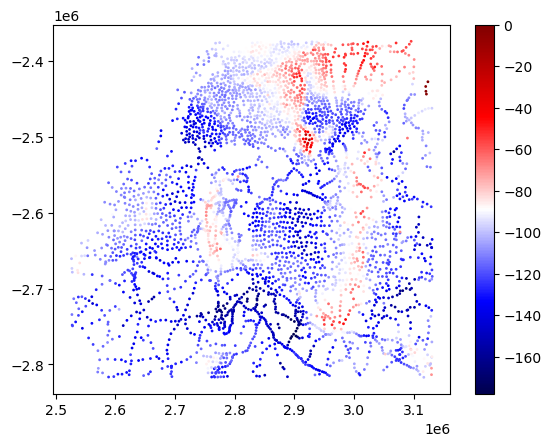

In [3]:
# plot data
import matplotlib.pyplot as plt
plt.scatter(gravdata[:,0], gravdata[:,1], c=gravdata[:,3], cmap='seismic',s=1)  # 'c' is the array of colors, and 'cmap' is the color map
plt.colorbar()  # Show color scale


#### SimPEG

SimPEG can direct use the xyz file as receiver_locations, and magnetic data as dobs, as z is postive up, so we do not need to change anything in here

In [4]:
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

In [5]:
receiver_locations = gravdata[:,0:3]
dobs = gravdata[:,-1]

#### Jif3D

For Jif3D x is pointing north, and z is postive down, so we need to change sign. Also the unit of gravity is m/s2, we need to change that as well.

In [6]:
from netCDF4 import Dataset

# Easting/Northing
MeasY = gravdata[:,0]
MeasX = gravdata[:,1]
# Change sign for height
MeasZ = -gravdata[:,2]
#convert data from mGal to m/s2
gz = gravdata[:,3] * 1e-5
#set a global error of 10^-5 m/s2
dgz = np.ones(gz.shape) * 1e-5
#subtract mean from data to retrieve anomalies
mgz = gz - np.mean(gz)

In [7]:
data_fh = Dataset("gravdata.nc", "w")
# The number of stations within the bounds specified above
nstat = MeasX.size
#create a dimension with the corret number of stations
statdim = data_fh.createDimension("StationNumber", nstat)
# create a one-dimensional array variable named MeasPosX of floating point type with a number of
#values specified by the dimension StationNumber
vmeasx = data_fh.createVariable("MeasPosX","f8",("StationNumber"))
#set the units metadata entry for the variable MeasPosX
vmeasx.units = "m"
vmeasx[:] = MeasX
#the other entries follow the same pattern, all are simple arrays with nstat values
vmeasy = data_fh.createVariable("MeasPosY","f8",("StationNumber"))
vmeasy.units = "m"
vmeasy[:] = MeasY
vmeasz = data_fh.createVariable("MeasPosZ","f8",("StationNumber"))
vmeasz.units = "m"
vmeasz[:] = MeasZ
vgz = data_fh.createVariable("Scalar_gravity","f8",("StationNumber"))
vgz.units = "m/s2"
vgz[:] = mgz
vdgz = data_fh.createVariable("dGz","f8",("StationNumber"))
vdgz.units = "m/s2"
vdgz[:] = dgz
#close the file to make sure everything is written to disk correctly
data_fh.close()

#### Tomofast-x

For Tomofast-x, we need to write a txt array with x,y,z,data. the first line is total number of data. z is also postive down

In [8]:
# Define the header, footer, and custom delimiter

gravdata_revers_z=gravdata.copy()
gravdata_revers_z[:,2]=-gravdata[:,2]

header = str(gravdata[:,0].size)
delimiter = ' '

# Save with additional options
np.savetxt('Gra_data.txt', gravdata_revers_z, fmt='%.5f', delimiter=delimiter, header=header,comments='')


## Mesh 
we try to use discretize to generate mesh for all
#### SimPEG

In [9]:
from discretize import TensorMesh

# Generate tensor mesh with top at z = 0 m
dx = 10000 # minimum cell size
dy = 10000 # minimum cell size
dz = 2000 # minimum cell size

nx = (gravdata[:,0].max()-gravdata[:,0].min())/dx  #  cell number in core area
ny = (gravdata[:,1].max()-gravdata[:,1].min())/dy  # cell number in core area
nz = 20 # cell number in core area

factor = 1.1 # padding factor

paddle_size = 10 # padding size
hx = [(dx, paddle_size, -factor), (dx, nx), (dx, paddle_size, factor)]  # discretization along x
hy = [(dy, paddle_size, -factor), (dy, ny), (dy, paddle_size, factor)]  # discretization along y
hz = [(dz, paddle_size, -factor), (dz, nz)]  # discretization along z
mesh = TensorMesh([hx, hy, hz], x0="CCN")

# Shift horizentally to match the core area
mesh.origin += np.r_[(gravdata[:,0].max()+gravdata[:,0].min())/2,
                     (gravdata[:,1].max()+gravdata[:,1].min())/2,
                     0.0]

Text(0.5, 1.0, 'Cell Log-Volumes #2')

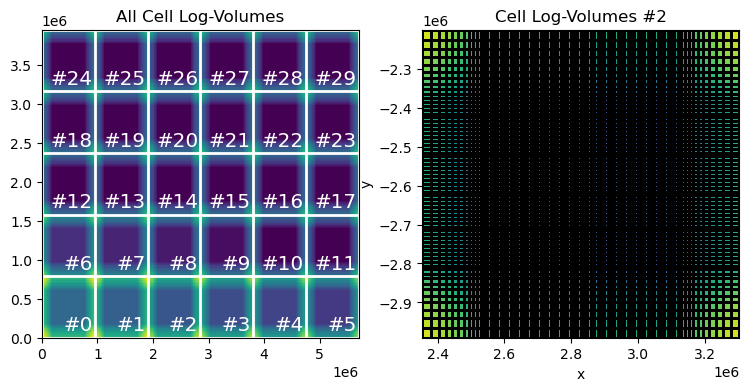

In [10]:
# The total number of cells
nC = mesh.nC

# An (nC, 3) array containing the cell-center locations
cc = mesh.gridCC

# A boolean array specifying which cells lie on the boundary
bInd = mesh.cell_boundary_indices

# The cell volumes
v = mesh.cell_volumes

# Plot all cells volumes or plot cell volumes for a particular horizontal slice
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mesh.plot_image(np.log10(v), grid=True, ax=ax1)
ax1.set_title("All Cell Log-Volumes")

cplot = mesh.plot_slice(np.log10(v), grid=True, ax=ax2, normal="Z", ind=2)
cplot[0].set_clim(np.min(np.log10(v)), np.max(np.log10(v)))
ax2.set_title("Cell Log-Volumes #2")

#### Jif3D
we want to reuse the mesh for Jif3D

In [11]:
startx = mesh.get_tensor('N')[1][0]
starty = mesh.get_tensor('N')[0][0]
startz = np.flip(-mesh.get_tensor('N')[2]).min()

# Layer thickness
bg_thickness = np.diff(np.flip(-mesh.get_tensor('N')[2]))

Northing = mesh.get_tensor('N')[1][1:]
Easting = mesh.get_tensor('N')[0][1:]
Depth = np.flip(-mesh.get_tensor('N')[2])[1:]

In [12]:
#create a 3D array of density values filled with zeros
Density = np.zeros([Depth.size,Easting.size,Northing.size])
bg_densities = np.zeros(Depth.size)


In [13]:
model_fh = Dataset("start_grav.nc", "w")
Northdim = model_fh.createDimension("Northing", Northing.size)
Eastdim = model_fh.createDimension("Easting", Easting.size)
Depthdim = model_fh.createDimension("Depth", Depth.size)
bgdim = model_fh.createDimension("bg_layers", bg_densities.size)
         
vnorth = model_fh.createVariable("Northing","f8",("Northing"))
vnorth[:] = Northing[:]
vnorth.units = "m"

vnorth_orig = model_fh.createVariable("Northing_Origin","f8")
vnorth_orig[:] = startx
         
veast = model_fh.createVariable("Easting","f8",("Easting"))
veast[:] = Easting[:]
veast.units = "m"
veast_orig = model_fh.createVariable("Easting_Origin","f8")
veast_orig[:] = starty
         
vdepth = model_fh.createVariable("Depth","f8",("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_fh.createVariable("Depth_Origin","f8")
vdepth_orig[:] = startz
         
vdens  = model_fh.createVariable("Density","f8",("Depth","Easting","Northing"))
vdens[:,:,:] = Density[:,:,:]
vdens.units = "kg/m3"
         
vbgdens = model_fh.createVariable("bg_densities","f8",("bg_layers"))
vbgdens[:] = bg_densities[:]
vbgdens.units = "kg/m3"
         
vbgthick = model_fh.createVariable("bg_thicknesses","f8",("bg_layers"))
vbgthick[:] = bg_thickness[:]
vbgthick.units = "m"

model_fh.close()  

#### Tomofast-x


In [14]:
# Extract mesh coordinates for Northing, Easting, and Depth
Northing = mesh.get_tensor('N')[1]
Easting = mesh.get_tensor('N')[0]
Depth = np.flip(-mesh.get_tensor('N')[2])

# Generate mesh grids for the original coordinates
[z_l, y_l, x_l] = np.meshgrid(Depth[0:-1], Northing[0:-1], Easting[0:-1])
[z_r, y_r, x_r] = np.meshgrid(Depth[1:], Northing[1:], Easting[1:])

# Generate index grids corresponding to each dimension
[z_i, y_i, x_i] = np.meshgrid(
    np.arange(1, Depth.size ),
    np.arange(1, Northing.size ),
    np.arange(1, Easting.size )
)

# Initial density
den_i = z_i - z_i

# Calculate the boundaries for each cell by adjusting coordinates with half thicknesses
mesh_tomofast = np.stack((
    x_l.flatten(),
    x_r.flatten(),
    y_l.flatten(),
    y_r.flatten(),
    z_l.flatten(),
    z_r.flatten(),
    den_i.flatten(),  # Initial density
    x_i.flatten(),
    y_i.flatten(),
    z_i.flatten()
))

# Transpose the array for saving: rows become columns
mesh_tomofast = mesh_tomofast.T

# Save the mesh data to a text file with a custom delimiter and no comments
header = str(mesh_tomofast.shape[0])  # Correctly convert the size to a string for the header
delimiter = ' '  # Single space as delimiter
fmt_specifiers = ['%.5f'] * 7 + ['%d'] * 3  # Create a list of format specifiers
fmt_string = ' '.join(fmt_specifiers)  # Join them into a single string separated by spaces

np.savetxt(
    'mesh.txt',
    mesh_tomofast,
    fmt=fmt_string,  # Format as floating point with one decimal
    delimiter=delimiter,
    header=header,
    comments=''  # No comment character
)
